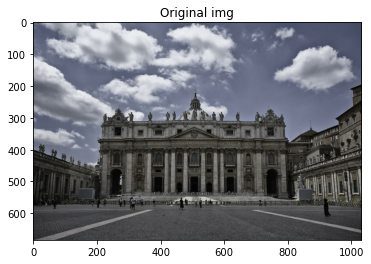

In [1]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import math


def make_homogeneous(column_vecs):
    return np.vstack((column_vecs, np.ones(column_vecs.shape[1])))


def get_rotation_matrix(unit_rotation_vector, theta):

    # Rodrigues formula
    # R = I + sin(theta) . K + (1 - cos(theta)).K**2

    K = np.array([
        [0.0, -unit_rotation_vector[2], unit_rotation_vector[1]],
        [unit_rotation_vector[2], 0.0, -unit_rotation_vector[0]],
        [-unit_rotation_vector[1], unit_rotation_vector[0], 0.0],
    ])
    a = np.eye(3)
    b = math.sin(theta) * K
    c = (1.0 - math.cos(theta)) * K @ K

    R = a + b + c
    return R


def get_rectification_rotation(normal, rotation_factor=1.0):

    # now the normals will be "from the camera", "inside" the surfaces
    normal = -normal

    z = np.array([0.0, 0.0, 1.0])

    rotation_vector = np.cross(normal, z)
    rotation_vector_norm = abs_sin_theta = np.linalg.norm(rotation_vector)
    unit_rotation_vector = rotation_vector / rotation_vector_norm
    theta = math.asin(abs_sin_theta) * rotation_factor
    print("theta: {}".format(theta * 180 / math.pi))

    R = get_rotation_matrix(unit_rotation_vector, theta)
    det = np.linalg.det(R)
    assert math.fabs(det - 1.0) < 0.0001
    print("R:\n{}".format(R))
    return R



#### New part
def get_valid_mask(x_array, y_array, valid_box):
    mask = ((x_array >= valid_box[:,0].min()) & 
            (x_array <= valid_box[:,0].max()) &
            (y_array >= valid_box[:,1].min()) & 
            (y_array <= valid_box[:,1].max()))
    return mask
#### END of New part 
def get_perspective_transform(img, R, K, clip_angle = None):
    #### New part
    import kornia.geometry as KG
    import torch
    h, w  = img.shape[:2]
    h_2, w_2 = h/2.0, w/2.0
    if clip_angle is None:
        clip_angle = 90
    angles_xyz = KG.rotation_matrix_to_angle_axis(torch.from_numpy(R)[None]).detach().cpu().numpy()[0]
    angles_xyz = np.rad2deg(angles_xyz)
    FOV_Y_2 = np.rad2deg(math.atan(h_2/K[1][1]))
    FOV_X_2 = np.rad2deg(math.atan(w_2/K[0][0]))
    
    dy = h_2 * (math.sin(np.deg2rad(clip_angle)) / math.sin(np.deg2rad(FOV_Y_2))) 
    dx = w_2 * (math.sin(np.deg2rad(clip_angle)) / math.sin(np.deg2rad(FOV_X_2)))

    center_x = w_2 * (1.0 + (math.sin(np.deg2rad(angles_xyz[1])) / math.tan(np.deg2rad(FOV_X_2)))) 
    center_y = h_2 * (1.0 + (math.sin(np.deg2rad(angles_xyz[0])) / math.tan(np.deg2rad(FOV_Y_2))))
    
    valid_box =  np.float32([[center_x - dx , center_y - dy], 
                      [center_x - dx, center_y + dy], 
                      [center_x + dx, center_y + dy],
                      [center_x + dx, center_y - dy]])

    print (f'valid_box = {valid_box}')
    #### END of New part
       
    scale = 1.0
    
    K_inv = np.linalg.inv(K)

    unscaled = True
    while unscaled:

        coords = np.where(img[:, :, 0] > 0)
        coords = np.array([coords[1], coords[0]])
        # NEW part
        mask = get_valid_mask(coords[0], coords[1], valid_box)
        coords = coords[:, mask]
        # END of new part
        coords = make_homogeneous(coords)

        # I really think I need K (even if estimated)
        print("K:\n{},\nR:\n{},\nK_inv: {}".format(K, R, K_inv))
        P = K @ R @ K_inv
        print("original P:\n{}".format(P))
        if scale != 1.0:
            unscaled = False
            print("scale: {}".format(scale))
            P[:2, :] *= scale

        new_coords = P @ coords
        new_coords = new_coords / new_coords[2, :]
        
        min_row = min(new_coords[1])
        max_row = max(new_coords[1])
        min_col = min(new_coords[0])
        max_col = max(new_coords[0])

        dst = np.float32([[min_col, min_row], 
                          [min_col, max_row], 
                          [max_col, max_row ],
                          [max_col, min_row]])
        dst = np.transpose(dst)
        dst = make_homogeneous(dst)

        if unscaled:
            new_bb_size = (max_row - min_row) * (max_col - min_col)
            scale = np.sqrt((coords.shape[1] * 2.0) / new_bb_size)
            if scale == 1.0:
                unscaled = False
                break
    print (new_coords)
    new_origin_x, new_origin_y = -np.min(dst[0]), -np.min(dst[1])
    
    translate_matrix = np.array([
        [1, 0, new_origin_x],
        [0, 1, new_origin_y],
        [0, 0, 1],
    ])
    
    dst[0,:] +=new_origin_x
    dst[1,:] +=new_origin_y
    print("scaled P:\n{}".format(P))
    print("translate_matrix:\n{}".format(translate_matrix))
    P = translate_matrix @ P
    print("new P:\n{}".format(P))
    outsize = (math.floor(np.max(dst[0])), math.floor(np.max(dst[1])))
    print("outsize: {}".format(outsize))
    
    return P, outsize

def show_transormation(img, K, normal, clip_angle = 70):
    Height, Width = img.shape[:2]
    h_2 = Height / 2.0
    w_2 = Width / 2.0
    for t in range(1):
        rotation_factor=1.0
        R = get_rectification_rotation(normal, rotation_factor=rotation_factor)
        # Get angles from normal
        # 
        #print("R:\n{}".format(R))
        H, outsize = get_perspective_transform(img, R, K, clip_angle=clip_angle)
        # use angles to crop the bounding box
        
        rectified = cv.warpPerspective(img, H, outsize)

        plt.figure(figsize=(9, 9))
        plt.title("get_perspective_transform - rotation_factor: {}".format(rotation_factor))
        plt.imshow(rectified)
        plt.show()
img = cv.cvtColor(cv.imread("99261069_5958624644.jpg", None), cv.COLOR_BGR2RGB)

plt.figure()
plt.title("Original img")
plt.imshow(img)
plt.show()

K = [[839.76184082,  0.,  516.], 
     [  0.,          839.76184082,  342.], 
     [  0.,          0.,        1.]]




theta: 81.89038554400581
R:
[[ 1.          0.          0.        ]
 [ 0.          0.14106736 -0.99      ]
 [ 0.          0.99        0.14106736]]


/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/kornia/augmentation/augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(


valid_box = [[-239.03229  478.76678]
 [-239.03229 1867.9617 ]
 [1271.0322  1867.9617 ]
 [1271.0322   478.76678]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 1.          0.          0.        ]
 [ 0.          0.14106736 -0.99      ]
 [ 0.          0.99        0.14106736]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.00000000e+00  6.08315328e-01 -6.51253085e+02]
 [ 0.00000000e+00  5.44253101e-01 -9.69253746e+02]
 [ 0.00000000e+00  1.17890568e-03 -2.62118381e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 1.          0.          0.        ]
 [ 0.          0.14106736 -0.99      ]
 [ 0.          0.99        0.14106736]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.00000000e+00  6.08315328e-01 -6.51253085e+02]
 [ 0.000

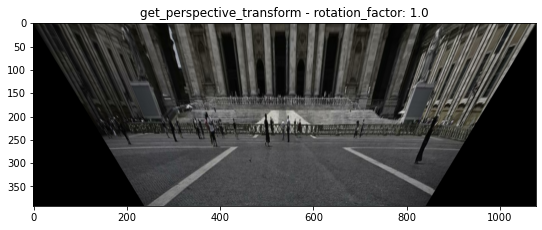

theta: 81.89038554400581
R:
[[ 1.          0.          0.        ]
 [ 0.          0.14106736 -0.99      ]
 [ 0.          0.99        0.14106736]]
valid_box = [[-410.1842   321.31433]
 [-410.1842  2025.4142 ]
 [1442.1842  2025.4142 ]
 [1442.1842   321.31433]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 1.          0.          0.        ]
 [ 0.          0.14106736 -0.99      ]
 [ 0.          0.99        0.14106736]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.00000000e+00  6.08315328e-01 -6.51253085e+02]
 [ 0.00000000e+00  5.44253101e-01 -9.69253746e+02]
 [ 0.00000000e+00  1.17890568e-03 -2.62118381e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 1.          0.          0.        ]
 [ 0.          0.14106736 -0.99      ]
 [ 0.          0.99        0.14106736]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0

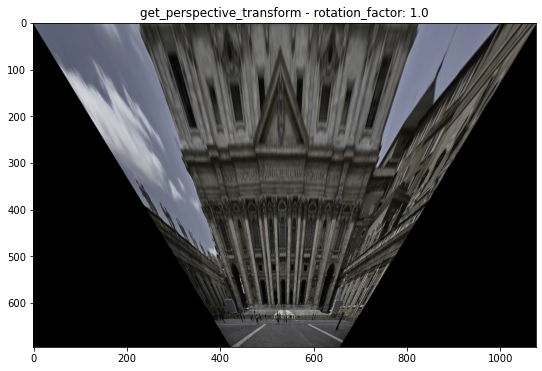

theta: 81.89038554400581
R:
[[ 1.          0.          0.        ]
 [ 0.          0.14106736 -0.99      ]
 [ 0.          0.99        0.14106736]]
valid_box = [[-436.0403   297.52783]
 [-436.0403  2049.2007 ]
 [1468.0403  2049.2007 ]
 [1468.0403   297.52783]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 1.          0.          0.        ]
 [ 0.          0.14106736 -0.99      ]
 [ 0.          0.99        0.14106736]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.00000000e+00  6.08315328e-01 -6.51253085e+02]
 [ 0.00000000e+00  5.44253101e-01 -9.69253746e+02]
 [ 0.00000000e+00  1.17890568e-03 -2.62118381e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 1.          0.          0.        ]
 [ 0.          0.14106736 -0.99      ]
 [ 0.          0.99        0.14106736]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0

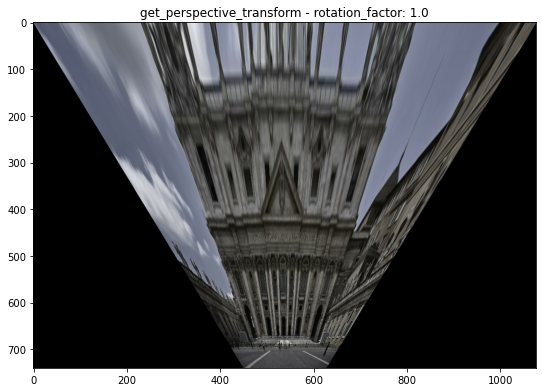

theta: 81.89038554400581
R:
[[ 1.          0.          0.        ]
 [ 0.          0.14106736 -0.99      ]
 [ 0.          0.99        0.14106736]]
valid_box = [[-454.6508   280.40695]
 [-454.6508  2066.3215 ]
 [1486.6508  2066.3215 ]
 [1486.6508   280.40695]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 1.          0.          0.        ]
 [ 0.          0.14106736 -0.99      ]
 [ 0.          0.99        0.14106736]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.00000000e+00  6.08315328e-01 -6.51253085e+02]
 [ 0.00000000e+00  5.44253101e-01 -9.69253746e+02]
 [ 0.00000000e+00  1.17890568e-03 -2.62118381e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 1.          0.          0.        ]
 [ 0.          0.14106736 -0.99      ]
 [ 0.          0.99        0.14106736]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0

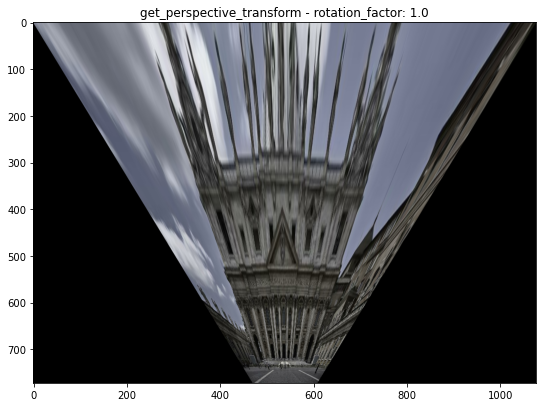

In [2]:

# rotation around x axis
y = -0.99
z = math.sqrt(1.0 - y**2)

normal = np.array([0.0, y, z])

for clip_angle in [50, 70, 75,  80]:
    show_transormation(img, K, normal, clip_angle=clip_angle)

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


theta: 66.31758849018811
R:
[[ 0.98347631 -0.09804917 -0.1521864 ]
 [-0.09804917  0.41819036 -0.90305215]
 [ 0.1521864   0.90305215  0.40166667]]
valid_box = [[-399.56473  410.91663]
 [-399.56473 1800.1116 ]
 [1110.4999  1800.1116 ]
 [1110.4999   410.91663]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.98347631 -0.09804917 -0.1521864 ]
 [-0.09804917  0.41819036 -0.90305215]
 [ 0.1521864   0.90305215  0.40166667]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.07698876e+00  4.56840187e-01 -6.32505873e+02]
 [-3.60699933e-02  7.85965862e-01 -8.71166943e+02]
 [ 1.81225667e-04  1.07536697e-03 -5.96212793e-02]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.98347631 -0.09804917 -0.1521864 ]
 [-0.09804917  0.41819036 -0.90305215]
 [ 0.1521864   0.90305215  0.40166667]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0

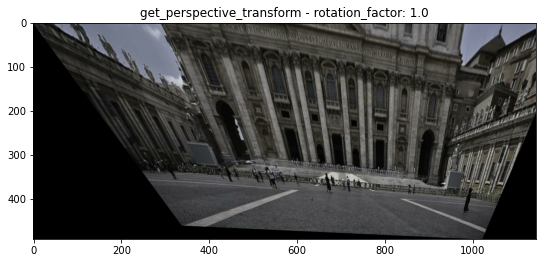

theta: 66.31758849018811
R:
[[ 0.98347631 -0.09804917 -0.1521864 ]
 [-0.09804917  0.41819036 -0.90305215]
 [ 0.1521864   0.90305215  0.40166667]]
valid_box = [[-570.7167   253.46417]
 [-570.7167  1957.564  ]
 [1281.6517  1957.564  ]
 [1281.6517   253.46417]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.98347631 -0.09804917 -0.1521864 ]
 [-0.09804917  0.41819036 -0.90305215]
 [ 0.1521864   0.90305215  0.40166667]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.07698876e+00  4.56840187e-01 -6.32505873e+02]
 [-3.60699933e-02  7.85965862e-01 -8.71166943e+02]
 [ 1.81225667e-04  1.07536697e-03 -5.96212793e-02]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.98347631 -0.09804917 -0.1521864 ]
 [-0.09804917  0.41819036 -0.90305215]
 [ 0.1521864   0.90305215  0.40166667]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0

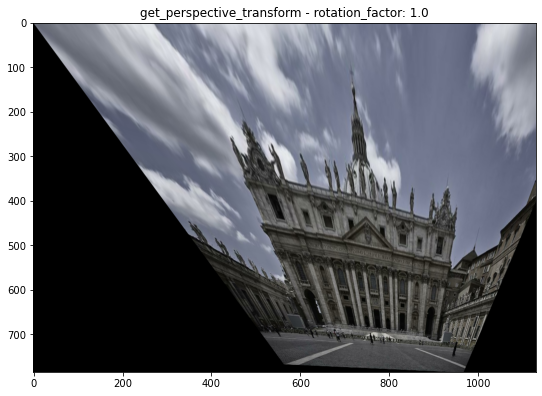

theta: 66.31758849018811
R:
[[ 0.98347631 -0.09804917 -0.1521864 ]
 [-0.09804917  0.41819036 -0.90305215]
 [ 0.1521864   0.90305215  0.40166667]]
valid_box = [[-596.57275  229.67767]
 [-596.57275 1981.3505 ]
 [1307.5078  1981.3505 ]
 [1307.5078   229.67767]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.98347631 -0.09804917 -0.1521864 ]
 [-0.09804917  0.41819036 -0.90305215]
 [ 0.1521864   0.90305215  0.40166667]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.07698876e+00  4.56840187e-01 -6.32505873e+02]
 [-3.60699933e-02  7.85965862e-01 -8.71166943e+02]
 [ 1.81225667e-04  1.07536697e-03 -5.96212793e-02]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.98347631 -0.09804917 -0.1521864 ]
 [-0.09804917  0.41819036 -0.90305215]
 [ 0.1521864   0.90305215  0.40166667]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0

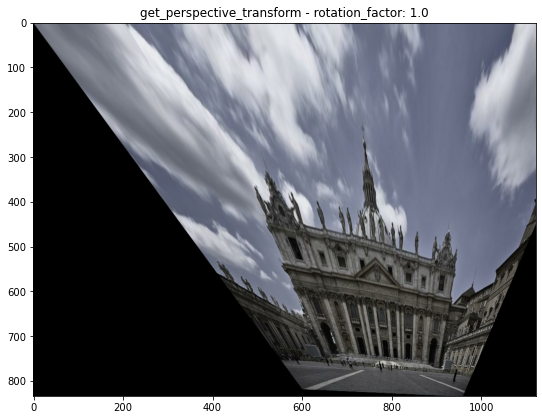

theta: 66.31758849018811
R:
[[ 0.98347631 -0.09804917 -0.1521864 ]
 [-0.09804917  0.41819036 -0.90305215]
 [ 0.1521864   0.90305215  0.40166667]]
valid_box = [[-615.1832   212.55681]
 [-615.1832  1998.4713 ]
 [1326.1184  1998.4713 ]
 [1326.1184   212.55681]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.98347631 -0.09804917 -0.1521864 ]
 [-0.09804917  0.41819036 -0.90305215]
 [ 0.1521864   0.90305215  0.40166667]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.07698876e+00  4.56840187e-01 -6.32505873e+02]
 [-3.60699933e-02  7.85965862e-01 -8.71166943e+02]
 [ 1.81225667e-04  1.07536697e-03 -5.96212793e-02]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.98347631 -0.09804917 -0.1521864 ]
 [-0.09804917  0.41819036 -0.90305215]
 [ 0.1521864   0.90305215  0.40166667]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0

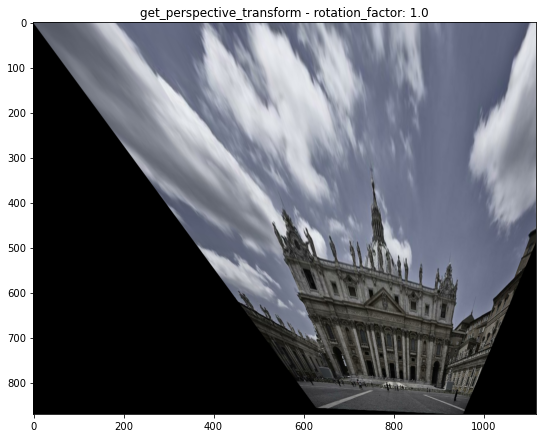

In [3]:

normal = np.array([-0.1521864, -0.90305215, 0.40166667])

for clip_angle in [50, 70, 75, 80]:
    show_transormation(img, K, normal, clip_angle=clip_angle)


